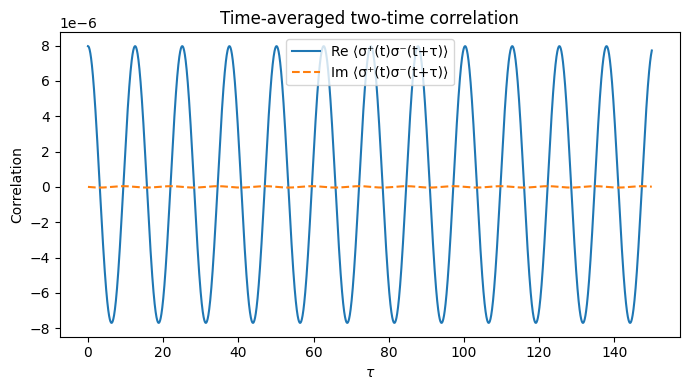

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

#Parameters 
tau_decay = 0.05
k = np.pi / 2 #Fixed momentum k
A0 = 0.2
omega = 0.501

Epk = 1.0
dEpk = 0.6
App = 0.2

#Drive
def A_t(t):
    return A0 * np.sin(omega * t)

def hz(t):
    A = A_t(t)
    return (
        Epk
        - dEpk * np.cos(k) * np.sin(A)
        - 2 * Epk * App * (1 - np.cos(A))
    )

def hy(t):
    A = A_t(t)
    return (
        dEpk * np.sin(k) * (1 - np.cos(A))
        - 2 * Epk * App * np.sin(A)
    )

#Bloch matrix
def B_matrix(t):
    return np.array([
        [-(1/tau_decay + 2j*hz(t)), 0.0, hy(t)],
        [0.0, -(1/tau_decay - 2j*hz(t)), hy(t)],
        [-2*hy(t), -2*hy(t), -2/tau_decay]
    ], dtype=complex)

b1 = np.array([0.0, 0.0, -2/tau_decay], dtype=complex)

#ODE wrapper
def odes_real(t, y):
    y_c = y[:3] + 1j*y[3:]
    dydt = B_matrix(t) @ y_c + b1
    return np.concatenate([dydt.real, dydt.imag])

#steady state ⟨σ⟩
c0 = np.array([0.0, 0.0, -1.0], dtype=complex)
y0 = np.concatenate([c0.real, c0.imag])

T = 75
t_eval = np.linspace(0, T, 6000)

sol = solve_ivp(
    odes_real, [0, T], y0,
    t_eval=t_eval, rtol=1e-9, atol=1e-12
)

c = sol.y[:3] + 1j*sol.y[3:]
sigma_m = c[0]
sigma_p = c[1]
sigma_z = c[2]
t = sol.t

#keep one steady-state period
T_drive = 2*np.pi / omega
t0 = T - T_drive
mask_t = t >= t0

t_vals = t[mask_t]
sigma_p_vals = sigma_p[mask_t]
sigma_z_vals = sigma_z[mask_t]

#evolve in τ
tau_max = 150
tau_eval = np.linspace(0, tau_max, 4000)

C_tau = []

for ti, sp, sz in zip(t_vals, sigma_p_vals, sigma_z_vals):

    #two-time correlation and modified initial condition at τ=0
    C0 = np.array([
        0.5 * (1 + sz),   # <σ+σ->
        0.0,              # <σ+σ+>
        -sp               # <σ+σz>
    ], dtype=complex)

    y0_tau = np.concatenate([C0.real, C0.imag])

#evolve in τ
    def corr_odes(tau, y):
        y_c = y[:3] + 1j*y[3:]
        dydt = B_matrix(ti + tau) @ y_c + np.array([0, 0, -2/tau_decay * sp])
        return np.concatenate([dydt.real, dydt.imag])

    sol_tau = solve_ivp(
        corr_odes, [0, tau_max], y0_tau,
        t_eval=tau_eval, rtol=1e-8, atol=1e-11
    )

    C = sol_tau.y[:3] + 1j*sol_tau.y[3:]
    C_tau.append(C[0])   # <σ+(t) σ-(t+τ)>

C_tau = np.array(C_tau)

#time-averaged correlation
C_avg = np.mean(C_tau, axis=0)

# Plot result
plt.figure(figsize=(7,4))
plt.plot(tau_eval, C_avg.real, label='Re ⟨σ⁺(t)σ⁻(t+τ)⟩')
plt.plot(tau_eval, C_avg.imag, '--', label='Im ⟨σ⁺(t)σ⁻(t+τ)⟩')
plt.xlabel(r'$\tau$')
plt.ylabel('Correlation')
plt.title('Time-averaged two-time correlation')
plt.legend()
plt.tight_layout()
plt.show()


In [17]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

tau_decay = 0.05
k = np.pi / 2  # Fixed momentum k
A0 = 0.2
omega = 0.501

Epk = 1.0
dEpk = 0.6
App = 0.2

#Drive
def A_t(t):
    return A0 * np.sin(omega * t)

def hz(t):
    A = A_t(t)
    return (
        Epk
        - dEpk * np.cos(k) * np.sin(A)
        - 2 * Epk * App * (1 - np.cos(A))
    )

def hy(t):
    A = A_t(t)
    return (
        dEpk * np.sin(k) * (1 - np.cos(A))
        - 2 * Epk * App * np.sin(A)
    )

#Bloch matrix
def B_matrix(t):
    return np.array([
        [-(1/tau_decay + 2j*hz(t)), 0.0, hy(t)],
        [0.0, -(1/tau_decay - 2j*hz(t)), hy(t)],
        [-2*hy(t), -2*hy(t), -2/tau_decay]
    ], dtype=complex)

b1 = np.array([0.0, 0.0, -2/tau_decay], dtype=complex)

#ODE wrapper
def odes_real(t, y):
    y_c = y[:3] + 1j*y[3:]
    dydt = B_matrix(t) @ y_c + b1
    return np.concatenate([dydt.real, dydt.imag])

#Steady state ⟨σ⟩
c0 = np.array([0.0, 0.0, -1.0], dtype=complex)
y0 = np.concatenate([c0.real, c0.imag])

T = 75
t_eval = np.linspace(0, T, 6000)

sol = solve_ivp(
    odes_real, [0, T], y0,
    t_eval=t_eval, rtol=1e-9, atol=1e-12
)

c = sol.y[:3] + 1j*sol.y[3:]
sigma_m = c[0]
sigma_p = c[1]
sigma_z = c[2]
t = sol.t

#Keep one steady-state period
T_drive = 2*np.pi / omega
t0 = T - T_drive
mask_t = t >= t0

t_vals = t[mask_t]
sigma_p_vals = sigma_p[mask_t]
sigma_z_vals = sigma_z[mask_t]

#evolve in τ
tau_max = 150
tau_eval = np.linspace(0, tau_max, 400)

#initialize 2D correlation array
C_matrix = np.zeros((len(t_vals), len(tau_eval)), dtype=complex)

for i, (ti, sp, sz) in enumerate(zip(t_vals, sigma_p_vals, sigma_z_vals)):

    #two-time correlation initial condition
    C0 = np.array([
        0.5 * (1 + sz),  # <σ+σ->
        0.0,             # <σ+σ+>
        -sp               # <σ+σz>
    ], dtype=complex)

    y0_tau = np.concatenate([C0.real, C0.imag])

    def corr_odes(tau, y):
        y_c = y[:3] + 1j*y[3:]
        dydt = B_matrix(ti + tau) @ y_c + np.array([0, 0, -2/tau_decay * sp])
        return np.concatenate([dydt.real, dydt.imag])

    sol_tau = solve_ivp(
        corr_odes, [0, tau_max], y0_tau,
        t_eval=tau_eval, rtol=1e-8, atol=1e-11
    )

    C = sol_tau.y[:3] + 1j*sol_tau.y[3:]
    C_matrix[i, :] = C[0]  # store <σ+(t) σ-(t+τ)>

plt.figure(figsize=(8,5))
plt.pcolormesh(tau_eval, t_vals, C_matrix.real, shading='auto', cmap='viridis')
plt.colorbar(label='Re ⟨σ⁺(t)σ⁻(t+τ)⟩')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$t$ (steady-state period)')
plt.title('Two-time correlation Re ⟨σ⁺(t)σ⁻(t+τ)⟩')
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


tau_decay = 0.05      # decay time
k = np.pi / 2         # fixed momentum
A0 = 0.2              # drive amplitude
omega = 0.501         # drive frequency

Epk = 1.0
dEpk = 0.6
App = 0.2

T_total = 75          # total time to reach steady state
n_points = 6000       # points for time evolution

#drive
def A_t(t):
    """Drive function: A(t) = A0 * sin(omega t)"""
    return A0 * np.sin(omega * t)

def hz(t):
    """z-component of the Hamiltonian"""
    A = A_t(t)
    return Epk - dEpk * np.cos(k) * np.sin(A) - 2 * Epk * App * (1 - np.cos(A))

def hy(t):
    """y-component of the Hamiltonian"""
    A = A_t(t)
    return dEpk * np.sin(k) * (1 - np.cos(A)) - 2 * Epk * App * np.sin(A)

#bloch matrix with decay
def B_matrix(t):
    """Bloch matrix for time t"""
    return np.array([
        [-(1/tau_decay + 2j*hz(t)), 0.0, hy(t)],
        [0.0, -(1/tau_decay - 2j*hz(t)), hy(t)],
        [-2*hy(t), -2*hy(t), -2/tau_decay]
    ], dtype=complex)

#decay
b1 = np.array([0.0, 0.0, -2/tau_decay], dtype=complex)

#ode wapper for solver
def odes_real(t, y):
    """
    Wrap complex ODE into real vector for solve_ivp.
    y[:3] = real parts, y[3:] = imaginary parts
    """
    y_c = y[:3] + 1j*y[3:]
    dydt = B_matrix(t) @ y_c + b1
    return np.concatenate([dydt.real, dydt.imag])

#steady state evolution 
c0 = np.array([0.0, 0.0, -1.0], dtype=complex)  # start in ground state
y0 = np.concatenate([c0.real, c0.imag])
t_eval = np.linspace(0, T_total, n_points)

sol = solve_ivp(odes_real, [0, T_total], y0, t_eval=t_eval, rtol=1e-9, atol=1e-12)

# Extract solution
c = sol.y[:3] + 1j*sol.y[3:]
sigma_p = c[1]
sigma_z = c[2]
t = sol.t

#folding, trying to keep one drive periodic 
T_drive = 2*np.pi / omega
t0 = T_total - T_drive
mask = t >= t0

t_vals = t[mask]
sigma_p_vals = sigma_p[mask]
sigma_z_vals = sigma_z[mask]

# two-time correlation
tau_max = 150
tau_eval = np.linspace(0, tau_max, 4000)
C_tau = []

for ti, sp, sz in zip(t_vals, sigma_p_vals, sigma_z_vals):
    # Initial condition for two-time correlation at tau=0
    C0 = np.array([
        0.5 * (1 + sz),  # <σ+σ->
        0.0,             # <σ+σ+>
        -sp               # <σ+σz>
    ], dtype=complex)
    y0_tau = np.concatenate([C0.real, C0.imag])

    #correlation ode with folding
    def corr_odes(tau, y, t_start):
        """
        Evolve two-time correlation with drive folding
        """
        y_c = y[:3] + 1j*y[3:]

        #attempt to fold the drive 
        t_eff = (t_start + tau) % T_drive
        hz_eff = hz(t_eff)
        hy_eff = hy(t_eff)

        B_eff = np.array([
            [-(1/tau_decay + 2j*hz_eff), 0.0, hy_eff],
            [0.0, -(1/tau_decay - 2j*hz_eff), hy_eff],
            [-2*hy_eff, -2*hy_eff, -2/tau_decay]
        ], dtype=complex)

        dydt = B_eff @ y_c + b1
        return np.concatenate([dydt.real, dydt.imag])

    sol_tau = solve_ivp(
        corr_odes, [0, tau_max], y0_tau,
        t_eval=tau_eval, rtol=1e-8, atol=1e-11,
        args=(ti,)
    )

    C = sol_tau.y[:3] + 1j*sol_tau.y[3:]
    C_tau.append(C[0])  # <σ+(t) σ-(t+τ)>

C_tau = np.array(C_tau)

#time averaged correlation 
C_avg = np.mean(C_tau, axis=0)

# plot
plt.figure(figsize=(7,4))
plt.plot(tau_eval, C_avg.real, label='Re ⟨σ⁺(t)σ⁻(t+τ)⟩')
plt.plot(tau_eval, C_avg.imag, '--', label='Im ⟨σ⁺(t)σ⁻(t+τ)⟩')
plt.xlabel(r'$\tau$')
plt.ylabel('Correlation')
plt.title('Time-averaged two-time correlation (with folding)')
plt.legend()
plt.tight_layout()
plt.show()


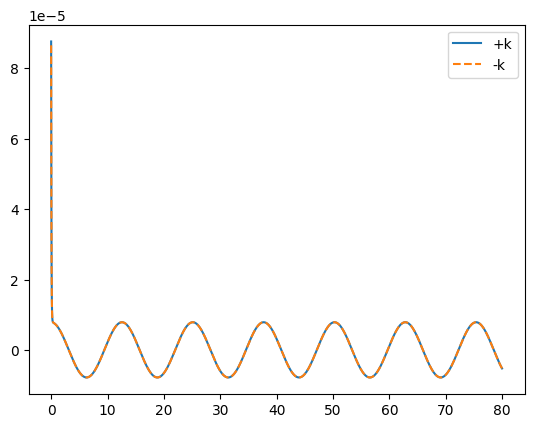

In [ ]:
def run(kval):
    global k
    k = kval

    sol = solve_ivp(odes,[0,T],y0,t_eval=t_eval)
    c = sol.y[:3] + 1j*sol.y[3:]
    sp = c[1]
    sz = c[2]
    t = sol.t

    mask = t > (T-Td)
    tvals = t[mask]
    spvals = sp[mask]
    szvals = sz[mask]

    C = []
    for ti,sp0,sz0 in zip(tvals,spvals,szvals):
        C0 = np.array([0.5*(1+sz0),0,-sp0])
        y0t = np.hstack([C0.real,C0.imag])

        def corr(tau,y):
            y = y[:3] + 1j*y[3:]
            dy = B(ti+tau)@y + np.array([0,0,-2/tau_decay*sp0])
            return np.hstack([dy.real,dy.imag])

        sol2 = solve_ivp(corr,[0,tau[-1]],y0t,t_eval=tau)
        C.append(sol2.y[0] + 1j*sol2.y[3])

    return np.mean(np.array(C),axis=0)

Ck = run(np.pi/2)
Cmk = run(-np.pi/2)

plt.plot(tau,Ck.real,label="+k")
plt.plot(tau,Cmk.real,'--',label="-k")
plt.legend()
plt.show()
